In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path :
    sys.path.append(module_path)

    
import _ressources.chain as chain
import _ressources.tools as tools
import _ressources.lumenclass as lc
import _ressources.analysis_tools.analysis as an


#from scipy.optimize import curve_fit


main_dir = '/Users/mathieuleverge/git/chain_lumen/_data/pumping/hydraulic/'

In [2]:
def calc_mu(theta) :
    return np.sin(theta)**2 / (2*theta - np.sin(2*theta))

def calc_chi(theta, gamma, kappa, ell0, L0) :
    mu = calc_mu(theta)
    return 0.5*mu*np.sin(theta)*gamma*kappa / (ell0*L0**3)
    #return gamma*kappa / (ell0*L0**3)

def calc_chi(theta, eps, kappa, ell0, L0) :
    mu = calc_mu(theta)
    return 0.5*mu*np.sin(theta)*eps*kappa / (ell0*L0**3)
    #return mu*np.sin(theta)*eps / (L0*ell0**3)


def lin(x, a, b) :
    return a*x+b

def fit_lin(t, N) :
    x, y = np.log(t), np.log(N)
    popt, pcov = curve_fit(lin, x, y)
    alpha, kappa = popt[0], np.exp(popt[1])
    alpha_std, kappa_std = pcov[0, 0], np.exp(pcov[1, 1])
    return kappa, alpha#, kappa_std, alpha_std
    

In [3]:
def plot_pumping(ca, path_list, plot_param_list, Nt_list, Lambdav=1.) :
    label = False
    Nt_list[ca] = {}
    for n in range(nsim) :
        Nt_list[ca][n] = np.loadtxt(os.path.join(path_list[ca][n], 'sim_nlum.dat'))
        if label :
            plt.plot(Nt_list[ca][n][:, 0]/Lambdav, Nt_list[ca][n][:, 1], color=plot_param_list[ca][0], marker=plot_param_list[ca][1], markersize=plot_param_list[ca][2], linewidth=plot_param_list[ca][3])
        else :
            label = True
            plt.plot(Nt_list[ca][n][:, 0]/Lambdav, Nt_list[ca][n][:, 1], color=plot_param_list[ca][0], marker=plot_param_list[ca][1], markersize=plot_param_list[ca][2], linewidth=plot_param_list[ca][3], label = r'$\Lambda_v$ = '+ str(ca))
    return Nt_list[ca]



# N(0) = 100

In [4]:
subdir = 'N100/ell10'
nsim=5

path_list_N100 = {}

# ca = 0
ca = 0
path_list_N100[ca] = {}
for n in range(nsim) :
    path_list_N100[ca][n] = os.path.join(main_dir, subdir, 'run'+str(ca)+'_'+str(n).zfill(4))

ca = 1e0
path_list_N100[ca] = {}
for n in range(nsim) :
    path_list_N100[ca][n] = os.path.join(main_dir, subdir, 'run1e0_'+str(n).zfill(4))
    
# ca = 1e-1
ca = 1e-1
path_list_N100[ca] = {}
for n in range(nsim) :
    path_list_N100[ca][n] = os.path.join(main_dir, subdir, 'run1e-1_'+str(n).zfill(4))
    
# ca = 1e-2
ca = 1e-2
path_list_N100[ca] = {}
for n in range(nsim) :
    path_list_N100[ca][n] = os.path.join(main_dir, subdir, 'run1e-2_'+str(n).zfill(4))
    
# ca = 1e-3
ca = 1e-3
path_list_N100[ca] = {}
for n in range(nsim) :
    path_list_N100[ca][n] = os.path.join(main_dir, subdir, 'run1e-3_'+str(n).zfill(4))
    
# ca = 1e-4
ca = 1e-4
path_list_N100[ca] = {}
for n in range(nsim) :
    path_list_N100[ca][n] = os.path.join(main_dir, subdir, 'run1e-4_'+str(n).zfill(4))

# ca = 1e-5
ca = 1e-5
path_list_N100[ca] = {}
for n in range(nsim) :
    path_list_N100[ca][n] = os.path.join(main_dir, subdir, 'run1e-5_'+str(n).zfill(4))
    

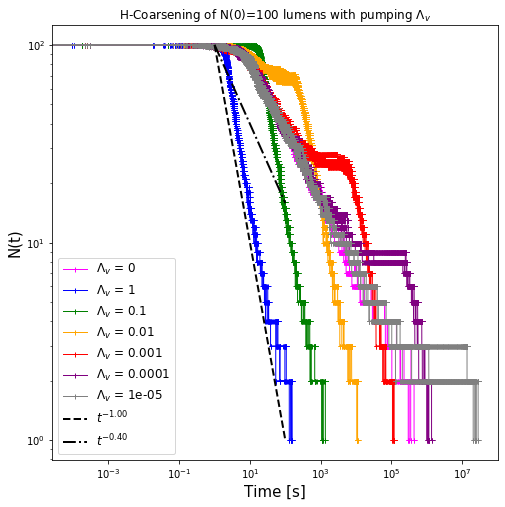

In [5]:
lw = 1
ms = 5

plot_param_list = {0 : ['magenta', '+', ms, lw], 
                   1 : ['blue', '+', ms, lw], 
                   1e-1 : ['green', '+', ms, lw], 
                   1e-2 : ['orange', '+', ms, lw], 
                   1e-3 :['red', '+', ms, lw], 
                   1e-4 :['purple', '+', ms, lw], 
                   1e-5 :['grey', '+', ms, lw]}

plt.figure(figsize=(8, 8))

plt.xscale('log')
plt.yscale('log')

nopump = 1
pump1e_0, pump1e_1, pump1e_2, pump1e_3, pump1e_4, pump1e_5 = 1, 1, 1, 1, 1, 1

Nt_list_N100 = {}

if nopump :
    ca = 0
    Nt_list_N100[ca] = plot_pumping(ca, path_list_N100, plot_param_list, Nt_list_N100)

if pump1e_0 :
    ca = 1
    Nt_list_N100[ca] = plot_pumping(ca, path_list_N100, plot_param_list, Nt_list_N100)
        
if pump1e_1 :
    ca = 1e-1
    Nt_list_N100[ca] = plot_pumping(ca, path_list_N100, plot_param_list, Nt_list_N100)
    
if pump1e_2 :
    ca = 1e-2
    Nt_list_N100[ca] = plot_pumping(ca, path_list_N100, plot_param_list, Nt_list_N100)
    
if pump1e_3 :
    ca = 1e-3
    Nt_list_N100[ca] = plot_pumping(ca, path_list_N100, plot_param_list, Nt_list_N100)
    
if pump1e_4 :
    ca = 1e-4
    Nt_list_N100[ca] = plot_pumping(ca, path_list_N100, plot_param_list, Nt_list_N100)
    
if pump1e_5 :
    ca = 1e-5
    Nt_list_N100[ca] = plot_pumping(ca, path_list_N100, plot_param_list, Nt_list_N100)



k1, a1 = 100, -1.
t1 = np.logspace(0, 2, 101)
plt.plot(t1, k1*t1**a1, label = r'$t^{'+"{:2.2f}".format(a1)+'}$', linewidth=2, linestyle='--', color = 'k')

k2, a2 = 100, -2./5.
t2 = np.logspace(0, 2, 101)
plt.plot(t2, k2*t2**a2, label = r'$t^{'+"{:2.2f}".format(a2)+'}$', linewidth=2, linestyle='-.', color = 'k')

plt.legend(loc=3, fontsize=12)

#plt.xlim(1e-1, 1e4)

plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('N(t)', fontsize=15)

plt.title(r'H-Coarsening of N(0)=100 lumens with pumping $\Lambda_v$')

plt.show()






## With pumping

Import successful !


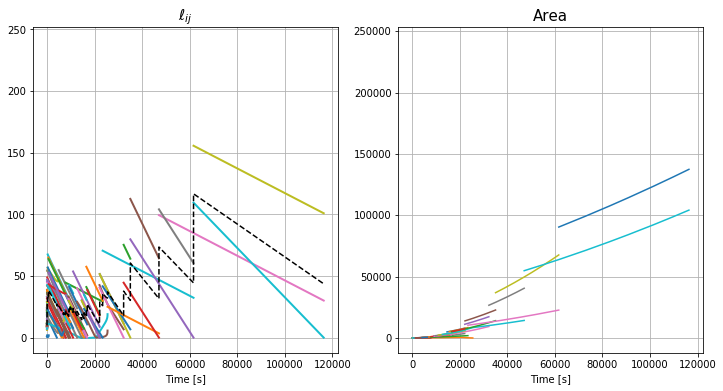

In [6]:

path_0 = os.path.join(main_dir, 'N100', 'ell10', 'run1e-3_0000')
L_pump_0, pos_pump_0 = tools.load_file(os.path.join(path_0, 'sim_all.dat'), hydroosmotic=False)

ell_pump_0 = tools.load_brfile(os.path.join(path_0, 'sim_bridges.dat'))


show_area=0
savefig=False
x_log = 0
y_log = 0

tools.plot_evolution_hydraulic(L_pump_0, ell_pump_0, savename='', show_totalarea=show_area, savefig=savefig, x_logscale=x_log, y_logscale=y_log, figsize=(12, 6))




## Without pumping

Import successful !


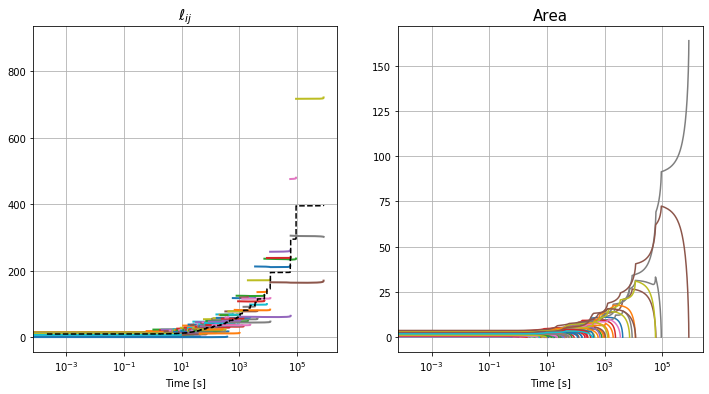

In [7]:

path_1 = os.path.join(main_dir, 'N100', 'ell10', 'run1e-3_0000_nopumping')
L_pump_1, pos_pump_1 = tools.load_file(os.path.join(path_1, 'sim_all.dat'), hydroosmotic=False)

ell_pump_1 = tools.load_brfile(os.path.join(path_1, 'sim_bridges.dat'))


show_area=0
savefig=0
x_log = 1
y_log = 0

savename = '/Users/mathieuleverge/Dropbox/M.Leverge/Lumen/Hydro-osmotic coarsening/Simulations/H-chain/N100_nopumping/evolution_linearscale.eps'
tools.plot_evolution_hydraulic(L_pump_1, ell_pump_1, savename=savename, show_totalarea=show_area, savefig=savefig, x_logscale=x_log, y_logscale=y_log, figsize=(12, 6))


# N(0) = 1000

In [4]:
subdir = 'N1000/ell10'
nsim=20 

path_list_N1000 = {}

# ca = 0
ca = 0
subsubdir = 'ca0'
path_list_N1000[ca] = {}
for n in range(nsim) :
    path_list_N1000[0][n] = os.path.join(main_dir, subdir, subsubdir, 'run'+str(n).zfill(4))

# ca = 1
ca = 1
subsubdir = 'ca1e0'
path_list_N1000[ca] = {}
for n in range(nsim) :
    path_list_N1000[ca][n] = os.path.join(main_dir, subdir, subsubdir, 'run'+str(n).zfill(4))    

# ca = 1e-1
ca = 1e-1
subsubdir = 'ca1e-1'
path_list_N1000[ca] = {}
for n in range(nsim) :
    path_list_N1000[ca][n] = os.path.join(main_dir, subdir, subsubdir, 'run'+str(n).zfill(4))
    
# ca = 1e-2
ca = 1e-2
subsubdir = 'ca1e-2'
path_list_N1000[ca] = {}
for n in range(nsim) :
    path_list_N1000[ca][n] = os.path.join(main_dir, subdir, subsubdir, 'run'+str(n).zfill(4))
    
# ca = 1e-3
ca = 1e-3
subsubdir = 'ca1e-3'
path_list_N1000[ca] = {}
for n in range(nsim) :
    path_list_N1000[ca][n] = os.path.join(main_dir, subdir, subsubdir, 'run'+str(n).zfill(4))
    
# ca = 1e-4
ca = 1e-4
subsubdir = 'ca1e-4'
path_list_N1000[ca] = {}
for n in range(nsim) :
    path_list_N1000[ca][n] = os.path.join(main_dir, subdir, subsubdir, 'run'+str(n).zfill(4))
    
# ca = 1e-5
ca = 1e-5
subsubdir = 'ca1e-5'
path_list_N1000[ca] = {}
for n in range(nsim) :
    path_list_N1000[ca][n] = os.path.join(main_dir, subdir, subsubdir, 'run'+str(n).zfill(4))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


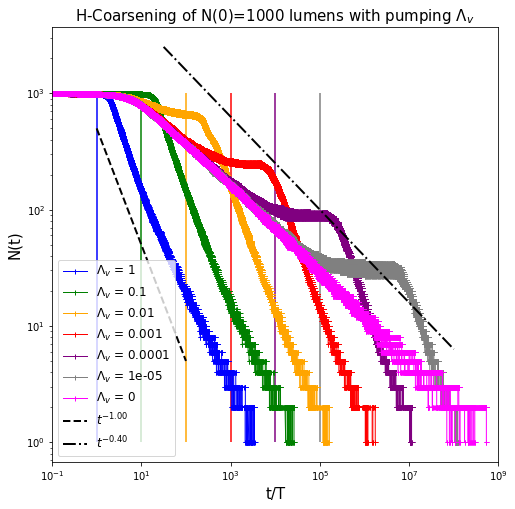

In [5]:
lw = 1
ms = 5

plot_param_list = {0 : ['magenta', '+', ms, lw], 
                   1 : ['blue', '+', ms, lw], 
                   1e-1 : ['green', '+', ms, lw], 
                   1e-2 : ['orange', '+', ms, lw], 
                   1e-3 :['red', '+', ms, lw], 
                   1e-4 :['purple', '+', ms, lw], 
                   1e-5 :['grey', '+', ms, lw]}

plt.figure(figsize=(8, 8))

plt.xscale('log')
plt.yscale('log')

nopump = 1
pump1e_0, pump1e_1, pump1e_2, pump1e_3, pump1e_4, pump1e_5 = 1, 1, 1, 1, 1, 1

Nt_list_N1000 = {}

#T = 

if pump1e_0 :
    ca = 1
    Nt_list_N1000[ca] = plot_pumping(ca, path_list_N1000, plot_param_list, Nt_list_N1000)
    plt.vlines(x=1/ca , ymin=1, ymax=1000, color = plot_param_list[ca][0])

        
if pump1e_1 :
    ca = 1e-1
    Nt_list_N1000[ca] = plot_pumping(ca, path_list_N1000, plot_param_list, Nt_list_N1000)
    plt.vlines(x=1/ca , ymin=1, ymax=1000, color = plot_param_list[ca][0])

    
if pump1e_2 :
    ca = 1e-2
    Nt_list_N1000[ca] = plot_pumping(ca, path_list_N1000, plot_param_list, Nt_list_N1000)
    plt.vlines(x=1/ca , ymin=1, ymax=1000, color = plot_param_list[ca][0])
    
if pump1e_3 :
    ca = 1e-3
    Nt_list_N1000[ca] = plot_pumping(ca, path_list_N1000, plot_param_list, Nt_list_N1000)
    plt.vlines(x=1/ca , ymin=1, ymax=1000, color = plot_param_list[ca][0])
    
if pump1e_4 :
    ca = 1e-4
    Nt_list_N1000[ca] = plot_pumping(ca, path_list_N1000, plot_param_list, Nt_list_N1000)
    plt.vlines(x=1/ca , ymin=1, ymax=1000, color = plot_param_list[ca][0])
    
if pump1e_5 :
    ca = 1e-5
    Nt_list_N1000[ca] = plot_pumping(ca, path_list_N1000, plot_param_list, Nt_list_N1000)
    plt.vlines(x=1/ca , ymin=1, ymax=1000, color = plot_param_list[ca][0])

#plt.hlines(y=1e5 , xmin=10, )

if nopump :
    ca = 0
    Nt_list_N1000[ca] = plot_pumping(ca, path_list_N1000, plot_param_list, Nt_list_N1000)

k1, a1 = 500, -1.
t1 = np.logspace(0, 2, 101)
plt.plot(t1, k1*t1**a1, label = r'$t^{'+"{:2.2f}".format(a1)+'}$', linewidth=2, linestyle='--', color = 'k')

k2, a2 = 10000, -2./5.
t2 = np.logspace(1.5, 8, 101)
plt.plot(t2, k2*t2**a2, label = r'$t^{'+"{:2.2f}".format(a2)+'}$', linewidth=2, linestyle='-.', color = 'k')

plt.legend(loc=3, fontsize=12)

plt.xlim(1e-1, 1e9)

plt.xlabel('t/T', fontsize=15)
plt.ylabel('N(t)', fontsize=15)

#plt.axis('equal')

plt.title(r'H-Coarsening of N(0)=1000 lumens with pumping $\Lambda_v$', fontsize=15)
plt.savefig('H-coarsening_N1000_pumping.eps', format='eps', dpi=100)
#plt.savefig('H-coarsening_N1000_pumping.png', format='png', dpi=100)
plt.show()




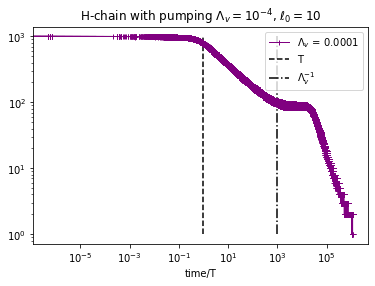

In [8]:
plt.xscale('log')
plt.yscale('log')

ell0 = 10

if pump1e_4 :
    ca = 1e-4
    Nt_list_N1000[ca] = plot_pumping(ca, path_list_N1000, plot_param_list, Nt_list_N1000, Lambdav=10)

plt.vlines(x=1 , ymin=1, ymax=1000, label = 'T', linestyle = '--')
plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, label = r'$\Lambda_v^{-1}$', linestyle = '-.')
#plt.vlines(x=1/ca , ymin=1, ymax=1000, label = r'$\ell_0*\Lambda_v^{-1}$', linestyle = 'dotted')
plt.xlabel('time/T')
plt.title(r'H-chain with pumping $\Lambda_v=10^{-4}$, $\ell_0 = 10$')
plt.legend()
plt.show()

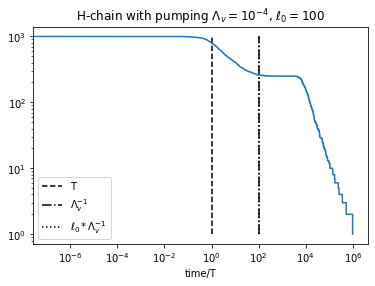

In [9]:
plt.xscale('log')
plt.yscale('log')

ell0 = 100
ca = 1e-4
Nt100_ca1e_4_ell100 = np.loadtxt(os.path.join(main_dir, 'N1000', 'ell100', 'ca1e-4', 'run0001', 'sim_nlum.dat'))

plt.plot(Nt100_ca1e_4_ell100[:, 0]/ell0, Nt100_ca1e_4_ell100[:, 1])

plt.vlines(x=1 , ymin=1, ymax=1000, label = 'T', linestyle = '--')
plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, label = r'$\Lambda_v^{-1}$', linestyle = '-.')
plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, label = r'$\ell_0*\Lambda_v^{-1}$', linestyle = 'dotted')
plt.xlabel('time/T')
plt.title(r'H-chain with pumping $\Lambda_v=10^{-4}$, $\ell_0 = 100$')
plt.legend()
plt.show()

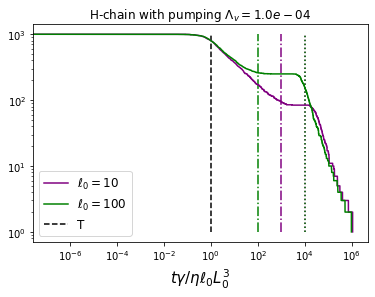

In [6]:
plt.xscale('log')
plt.yscale('log')
ca = 1e-4
T = 1.
N0 = 1000
plt.vlines(x=T , ymin=1, ymax=1000, label = 'T', linestyle = '--')


ell0 = 10
plt.plot(Nt_list_N1000[ca][0][:, 0]/ell0, Nt_list_N1000[ca][0][:, 1], label = r'$\ell_0=10$', color='purple')
plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='purple')
plt.vlines(x=ell0/(ca*ell0) , ymin=1, ymax=1000, linestyle = 'dotted', color='purple')

ell0 = 100
Nt100_ca1e_4_ell100 = np.loadtxt(os.path.join(main_dir, 'N1000/ell100/ca1e-4/run0001/sim_nlum.dat'))

plt.plot(Nt100_ca1e_4_ell100[:, 0]/ell0, Nt100_ca1e_4_ell100[:, 1], label = r'$\ell_0=100$', color='green')
plt.vlines(x=1./(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='green')
plt.vlines(x=ell0/(ca*ell0) , ymin=1, ymax=1000, linestyle = 'dotted', color='green')

L0 = 1
tm = (2*ca/(2*L0+ell0)**(-5./3)) * T**(-2./3)

#Tp = 1./ca
#plt.vlines(x=Tp , ymin=1, ymax=1000, linestyle = 'dotted', color='purple')
#plt.vlines(x=tm , ymin=1, ymax=1000, linestyle = '-.', color='red')



plt.xlabel(r'$t\gamma / \eta \ell_0 L_0^3$', fontsize=15)
plt.title(r'H-chain with pumping $\Lambda_v='+"{:1.1e}".format(ca)+'$')
plt.legend(fontsize=12)
plt.show()

# Distribution

In [6]:
def find_tstep(time_list, t0) :
    return np.argmin(np.abs(time_list - t0))

def calc_avg_distrib(X_dict, Y_dict) :
    X_array = np.array([X_dict[k] for k in X_dict.keys()])
    X_avg = np.average(X_array, axis=0)

    Y_array = np.array([Y_dict[k] for k in Y_dict.keys()])
    Y_avg = np.average(Y_array, axis=0)
    return X_avg, Y_avg


In [4]:
nsim = 20

In [275]:
Nt_1000_ca1e_4 = {}
Nt_1000_ca1e_3 = {}
for k in range(nsim) :
    Nt_1000_ca1e_4[k] = np.loadtxt(os.path.join(main_dir, 'N1000/ell100/ca1e-4/run'+str(k).zfill(4), 'sim_nlum.dat'))
    Nt_1000_ca1e_3[k] = np.loadtxt(os.path.join(main_dir, 'N1000/ell100/ca1e-3/run'+str(k).zfill(4), 'sim_nlum.dat'))
    

In [8]:
D_Nt1000_ca1e_4 = {}
T_list = {}

for k in range(nsim) :
    d = open(os.path.join(main_dir, 'N1000/ell100/ca1e-4/run'+str(k).zfill(4)+'/distrib_length.dat'), 'r').readlines()
    D_Nt1000_ca1e_4[k] = [an.distrib(d[i], nbins=30) for i in range(int(len(d)))]
    T_list[k] = np.array([D_Nt1000_ca1e_4[k][i][0] for i in range(len(D_Nt1000_ca1e_4[k]))])
    print(k)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [317]:
def make_T_dict(folder, npts, nsim=20, log_tmin=-3, log_tmax=7) :
    time_plot_list = np.logspace(log_tmin, log_tmax, npts)
    T_dict = {}
    for k in range(nsim) :
        T_dict[k] = np.loadtxt(os.path.join(folder, 'run'+str(k).zfill(4)+'/distrib_length.dat'), usecols=0)
    return T_dict, time_plot_list

def make_step_dict(T_dict, time_plot_list, npts, nsim) :
    step_dict = {}
    for n in range(npts) :
        step_dict[n] = {}
        for k in range(nsim) :
            step_dict[n][k] = np.argmin(np.abs(T_dict[k] - time_plot_list[n]))
    return step_dict

def plot_distrib2(step, nsim, folder, T_dict, time_plot_list, step_dict, Nt, show_hist=True, savefig=False, savename='pic.png', rescaled=True, extension='png') :
    L = []
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    
    ax[0].set_xlim(0.1, 1.80)
    ax[0].set_ylim(0., 1.)
    
    for k in range(nsim) :
        try :
            len_sim = len(T_dict[k])       # Length of the sim k
            step_sim = step_dict[step][k]     # Corresponding step for k
            data = np.genfromtxt(os.path.join(folder, 'run'+str(k).zfill(4)+'/distrib_length.dat'), skip_header=step_sim, skip_footer=len_sim-step_sim-1)
            t_sim, lengths_sim = data[0], data[1:]

            new_bins = np.max([10, int(np.log10(len(lengths_sim)))*10])

            #print(len(lengths_sim), bins, new_bins)

            L += [lengths_sim]
            weights = np.ones_like(lengths_sim)/float(len(lengths_sim))
            if show_hist :
                ax[0].hist(lengths_sim/np.average(lengths_sim), bins=new_bins, label=t_sim, alpha=0.1, weights=weights)

            ax[1].plot(Nt[k][:, 0], Nt[k][:, 1])
            s = np.argmin(np.abs(Nt[k][:,0]-t_sim))
            ax[1].scatter(Nt[k][s, 0], Nt[k][s, 1])
        except :
            pass
        
    new_L = np.concatenate([L[n] for n in range(len(L))])
    weights = np.ones_like(new_L)/float(len(new_L))
    
    y, x = np.histogram(new_L, bins=new_bins, weights=weights)
    
    new_x = 0.5*(x[1:]+x[:-1])
    ax[0].plot(new_x/np.average(new_L), y, color = 'k')
    
    if rescaled :
        ax[0].set_xlabel(r'$L/\bar{L}$', fontsize=12)
    else :
        ax[0].set_xlabel(r'$L$', fontsize=12)
    ax[0].set_ylabel(r'$\phi_L(t)/N(t)$', fontsize=12)
    
    ax[1].set_xlabel(r'Time [s]', fontsize=12)
    ax[1].set_ylabel(r'$N(t)$', fontsize=12)
    
    plt.suptitle('t = '+"{:2.2e}".format(time_plot_list[step]), fontsize=20)
    if savefig :
        plt.savefig(savename, format = extension)
        plt.close()
    else :
        plt.show()
    

# $c_a = 10^{-4}$

In [319]:
npts = 101
nsim = 20
folder = os.path.join(main_dir, 'N1000/ell100/ca1e-4/')

T_dict, time_plot_list = make_T_dict(folder = folder, npts=npts, nsim=nsim, log_tmin=0, log_tmax=7)
step_dict = make_step_dict(T_dict, time_plot_list, npts, nsim)


In [333]:

step=78
show_hist = True
folder = os.path.join(main_dir, 'N1000/ell100/ca1e-4/')
folder2 = '/Users/mathieuleverge/Documents/cavidoc/hydraulic/'
savename = os.path.join(folder2, 'pic'+str(step).zfill(4)+'.eps')
plot_distrib2(step=step, nsim=nsim, folder=folder, T_dict=T_dict, time_plot_list=time_plot_list, step_dict=step_dict, Nt=Nt_1000_ca1e_4, show_hist=show_hist, savefig=True, savename=savename, rescaled=True, extension='eps')




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [312]:
make_movie=False

if make_movie :
    for n in range(npts) :
        step=n

        show_hist = True
        folder = os.path.join(main_dir, 'N1000/ell100/ca1e-4/')
        folder2 = '/Users/mathieuleverge/Documents/cavidoc/hydraulic/pumping_distribution_ca1e-4_rescaled/'
        savename = os.path.join(folder2, 'pic'+str(n).zfill(4)+'.png')
        plot_distrib2(step=step, nsim=nsim, folder=folder, T_dict=T_dict, time_plot_list=time_plot_list, step_dict=step_dict, Nt=Nt_1000_ca1e_4, show_hist=show_hist, savefig=True, savename=savename, rescaled=True)



## Multiple distributions

In [334]:
steps = {'A' : [5, [1, 0]], 
         'B' : [40, [2, 0]], 
         'C' : [65, [3, 0]], 
         'D' : [78, [1, 1]], 
         'E' : [85, [2, 1]], 
         'F' : [90, [3, 1]]}

In [351]:
def plot_distrib3(steps, nsim, folder, T_dict, time_plot_list, step_dict, Nt, show_hist=True, rescaled=True, savefig=False, savename='pics.png', extension='png') :
    
    fig, ax = plt.subplots(4, 2, figsize=(8, 20))
    
    ax[0, 0].set_xscale('log')
    ax[0, 0].set_yscale('log')
    ax[0, 0].set_xlabel(r'Time [s]', fontsize=12)
    ax[0, 0].set_ylabel(r'$N(t)$', fontsize=12)


    for index in steps.keys() :
        i, j = steps[index][1]
        step = steps[index][0]
        
        ax[i, j].set_xlim(0.1, 1.80)
        ax[i, j].set_ylim(0., 1.)
        
        L = []
        for k in range(nsim) :
            try :
                len_sim = len(T_dict[k])       # Length of the sim k
                step_sim = step_dict[step][k]     # Corresponding step for k
                data = np.genfromtxt(os.path.join(folder, 'run'+str(k).zfill(4)+'/distrib_length.dat'), skip_header=step_sim, skip_footer=len_sim-step_sim-1)
                t_sim, lengths_sim = data[0], data[1:]

                new_bins = np.max([10, int(np.log10(len(lengths_sim)))*10])

                #print(len(lengths_sim), bins, new_bins)

                L += [lengths_sim]
                weights = np.ones_like(lengths_sim)/float(len(lengths_sim))
                if show_hist :
                    ax[i, j].hist(lengths_sim/np.average(lengths_sim), bins=new_bins, label=t_sim, alpha=0.1, weights=weights)

                ax[0, 0].plot(Nt[k][:, 0], Nt[k][:, 1])
                s = np.argmin(np.abs(Nt[k][:,0]-t_sim))
                ax[0, 0].scatter(Nt[k][s, 0], Nt[k][s, 1])
            except :
                pass

        new_L = np.concatenate([L[n] for n in range(len(L))])
        weights = np.ones_like(new_L)/float(len(new_L))

        y, x = np.histogram(new_L, bins=new_bins, weights=weights)

        new_x = 0.5*(x[1:]+x[:-1])
        ax[i, j].plot(new_x/np.average(new_L), y, color = 'k')

        #if rescaled :
        #    ax[i, j].set_xlabel(r'$L/\bar{L}$', fontsize=12)
        #else :
        #    ax[i, j].set_xlabel(r'$L$', fontsize=12)
        #ax[i, j].set_ylabel(r'$\phi_L(t)/N(t)$', fontsize=12)

    if savefig :
        plt.savefig(savename, format = extension)
        plt.close()
    else :
        plt.show()

In [352]:

plot_distrib3(steps=steps, nsim=nsim, folder=os.path.join(main_dir, 'N1000/ell100/ca1e-4/'), T_dict=T_dict, time_plot_list=time_plot_list, step_dict=step_dict, Nt=Nt_1000_ca1e_4, show_hist=True, rescaled=True, savefig=True, extension='eps', savename='distribution_ca1e-4.eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

# $c_a = 10^{-3}$

In [313]:
npts = 101
nsim = 20
folder = os.path.join(main_dir, 'N1000/ell100/ca1e-3/')

T_dict, time_plot_list = make_T_dict(folder = folder, npts=npts, nsim=nsim, log_tmin=0, log_tmax=6)
step_dict = make_step_dict(T_dict, time_plot_list, npts, nsim)



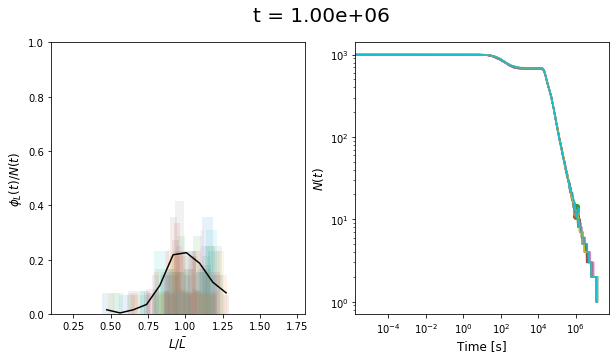

In [314]:
step=100
show_hist = True

folder3 = '/Users/mathieuleverge/Documents/cavidoc/hydraulic/pumping_distribution_ca1e-3/'
savename = os.path.join(folder3, 'pic'+str(n).zfill(4)+'.png')
plot_distrib2(step=step, nsim=nsim, folder=folder, T_dict=T_dict, time_plot_list=time_plot_list, step_dict=step_dict, Nt=Nt_1000_ca1e_3, show_hist=show_hist, savefig=False, savename=savename, rescaled=True)



In [316]:
make_movie=False

if make_movie :
    for n in range(npts) :
        step=n

        show_hist = True
        folder = os.path.join(main_dir, 'N1000/ell100/ca1e-3/')
        folder2 = '/Users/mathieuleverge/Documents/cavidoc/hydraulic/pumping_distribution_ca1e-3_rescaled/'
        savename = os.path.join(folder2, 'pic'+str(n).zfill(4)+'.png')
        plot_distrib2(step=step, nsim=nsim, folder=folder, T_dict=T_dict, time_plot_list=time_plot_list, step_dict=step_dict, Nt=Nt_1000_ca1e_3, show_hist=show_hist, savefig=True, savename=savename, rescaled=True)




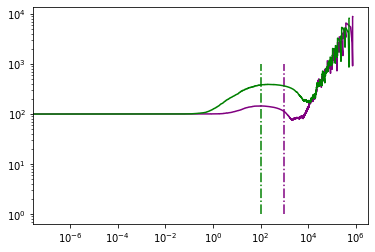

In [129]:
ellt_ca1e_4 = np.loadtxt(os.path.join(main_dir, 'N1000/ell100/ca1e-4/run0001/sim_ell_avg.dat'))
ellt_ca1e_3 = np.loadtxt(os.path.join(main_dir, 'N1000/ell100/ca1e-3/run0001/sim_ell_avg.dat'))

plt.xscale('log')
plt.yscale('log')
ell0 = 10
plt.plot(ellt_ca1e_3[:-10, 0]/ell0, ellt_ca1e_3[:-10, 1], color = 'purple')
plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='purple')
ell0 = 100
plt.plot(ellt_ca1e_4[:-10, 0]/ell0, ellt_ca1e_4[:-10, 1], color = 'g')
plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='green')


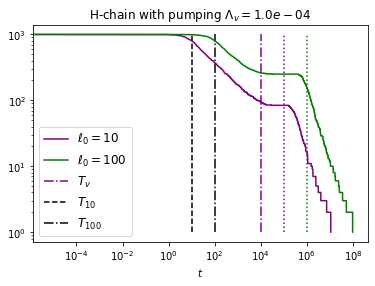

In [170]:
plt.xscale('log')
plt.yscale('log')
ca = 1e-4
#plt.vlines(x=ell0 , ymin=1, ymax=1000, label = 'T', linestyle = '--')

ell0 = 10
plt.plot(Nt_list_N1000[ca][0][:, 0], Nt_list_N1000[ca][0][:, 1], label = r'$\ell_0=10$', color='purple')
plt.vlines(x=1/(ca) , ymin=1, ymax=1000, label = r'$T_{v}$', linestyle = '-.', color='purple')
plt.vlines(x=ell0 , ymin=1, ymax=1000, label = r'$T_{10}$', linestyle = '--')
plt.vlines(x=ell0/(ca) , ymin=1, ymax=1000, linestyle = 'dotted', color='purple')

ell0 = 100
Nt100_ca1e_4_ell100 = np.loadtxt(os.path.join(main_dir, 'N1000', 'ell100', 'ca1e-4', 'run0001', 'sim_nlum.dat'))

plt.plot(Nt100_ca1e_4_ell100[:, 0], Nt100_ca1e_4_ell100[:, 1], label = r'$\ell_0=100$', color='green')
#plt.vlines(x=1/(ca) , ymin=1, ymax=1000, label = r'$T_{v}^{'+str(ell0)+'} = 1/(\Lambda_v)$', linestyle = '-.', color='green')
plt.vlines(x=ell0 , ymin=1, ymax=1000, label = r'$T_{100}$', linestyle = '-.')

plt.vlines(x=ell0/(ca) , ymin=1, ymax=1000, linestyle = 'dotted', color='green')


plt.xlabel(r'$t$')
plt.title(r'H-chain with pumping $\Lambda_v='+"{:1.1e}".format(ca)+'$')
plt.legend(fontsize=12)
plt.show()

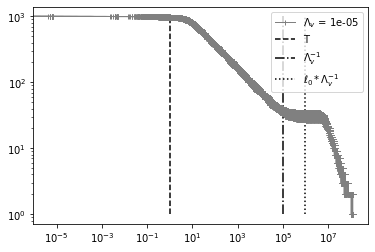

In [49]:
plt.xscale('log')
plt.yscale('log')
if pump1e_5 :
    ca = 1e-5
    Nt_list_N1000[ca] = plot_pumping(ca, path_list_N1000, plot_param_list, Nt_list_N1000)

plt.vlines(x=1 , ymin=1, ymax=1000, label = 'T', linestyle = '--')
plt.vlines(x=1/ca , ymin=1, ymax=1000, label = r'$\Lambda_v^{-1}$', linestyle = '-.')
plt.vlines(x=1/ca*10 , ymin=1, ymax=1000, label = r'$\ell_0*\Lambda_v^{-1}$', linestyle = 'dotted')
plt.legend()
plt.show()

# Distribution

In [53]:
Nt = np.loadtxt('/Users/mathieuleverge/git/chain_lumen/_data/pumping/hydraulic/N100/ell10/out0000/sim_nlum.dat')

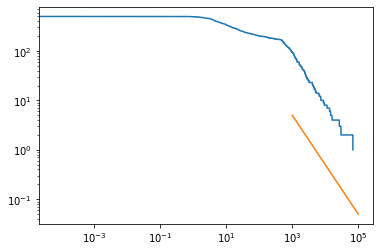

In [56]:
plt.xscale('log')
plt.yscale('log')
plt.plot(Nt[:, 0], Nt[:, 1])

t = np.logspace(3, 5., 101)
k, a = 5000., -1
plt.plot(t, k*t**a)